<a href="https://colab.research.google.com/github/yvsim001/projekt/blob/main/vww_modell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 -m pip install --upgrade tensorflow
!python3 -m pip install --upgrade jupyter matplotlib numpy pandas scipy scikit-learn keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-addons


In [ ]:

!pip install --upgrade tensorflow keras
from tensorflow.keras.layers import Layer  # For example, importing Layer from Keras


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
IMAGE_SIZE = 96
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
#BATCH_SIZE = 32 # ist eine Gruppe von n Daten aus den Trainingsdaten, die es ermöglicht, die Parameter zu verbessern, basierend auf dem Fehler, der mit diesen Daten berechnet wird.
#EPOCHS = 20 #20 Durchgang durch die Daten(training_daten), um die grundlegenden Parameter zu erhalten(1).
#1 passage= epoch kann 20 Iterationen haben, so dass eine Iteration die Parameter des Modells mit einem Batch von n Daten gleicher Größe aber unterschiedlicher Werte modifiziert.
# Am Ende des Durchlaufs aller Daten(1) wird das trainierte Modell evaluiert und dann mit neuen Daten weiter trainiert (Validierung), um Overfitting zu vermeiden und die Parameter anzupassen(2).
#1 epochs = trainingdatasize/batch_size = n Iterationen = 1 Durchgang.
#Eine Iteration = Lesen eines Stapels von n Daten.


#Der Datensatz wird vorverarbeitet, um auf zu trainieren.
#Bilder, die mindestens eine Person enthalten, die mehr als 2,5% des Quellbildes einnimmt.

In [ ]:
#vw_coco2014_96


In [ ]:
!wget https://www.silabs.com/public/files/github/machine_learning/benchmarks/datasets/vw_coco2014_96.tar.gz
!tar xf vw_coco2014_96.tar.gz

--2024-06-13 08:48:03--  https://www.silabs.com/public/files/github/machine_learning/benchmarks/datasets/vw_coco2014_96.tar.gz
Resolving www.silabs.com (www.silabs.com)... 23.210.110.200
Connecting to www.silabs.com (www.silabs.com)|23.210.110.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234810765 (224M) [application/x-gzip]
Saving to: ‘vw_coco2014_96.tar.gz.2’

vw_coco2014_96.tar. 100%[===================>] 223.93M   395MB/s    in 0.6s    

2024-06-13 08:48:04 (395 MB/s) - ‘vw_coco2014_96.tar.gz.2’ saved [234810765/234810765]



In [ ]:
#BASE_DIR = os.path.join(os.getcwd(), '/content/drive/MyDrive/vw_coco2014_96/vw_coco2014_96')
BASE_DIR = "./vw_coco2014_96/"
# LINK = https://www.silabs.com/public/files/github/machine_learning/benchmarks/datasets/vw_coco2014_96.tar.gz

In [ ]:
import numpy as np

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

def mobilenet_v1():
    # Mobilenet parameters
    input_shape = [96,96,3] # resized to 96x96 per EEMBC requirement
    num_classes = 2 # person and non-person
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 9th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 10th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 11th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 12th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = mobilenet_v1()
model.summary()    #Model Details

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 48, 48, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 48, 48, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_54 (Activation)           │ (None, 48, 48, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_26                  │ (None, 48, 48, 8)           │              80 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 48, 48, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_55 (Activation)           │ (None, 48, 48, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 48, 48, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_27                  │ (None, 24, 24, 16)          │             160 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_57 (Activation)           │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 24, 24, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_58 (Activation)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_28                  │ (None, 24, 24, 32)          │             320 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 221,794 (866.38 KB)

 Trainable params: 216,322 (845.01 KB)

 Non-trainable params: 5,472 (21.38 KB)

In [ ]:
def custom_generator(generator):
  for batch_x, batch_y in generator:
    if batch_x.shape[0] == generator.batch_size:
      yield batch_x, batch_y # Yield only full batches

random_translation = tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05)

def augment(image, label):
    # Random horizontal flip (flipping de l'image horizontalement)
    image = tf.image.random_flip_left_right(image)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random width and height shift (décalages aléatoires en largeur et hauteur)
    #image = tf.image.random_translation(image, 0.05 * IMAGE_SIZE, 0.05 * IMAGE_SIZE)

    image = random_translation(image)


    # Random zoom
    zoom_range = 0.1
    image = tf.image.central_crop(image, central_fraction=(1-zoom_range))
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    # Rescaling (to normalize pixel values)
    image = image * (1. / 255)

    return image, label

In [ ]:


batch_size = 50
validation_split = 0.1

#objekt class
#  generiert einen Datenstapel aus dem definierten Bild und trennt ihn in Training und Validierung (10%)
#datagen = tf.keras.preprocessing.image_dataset_from_directory(
#    rotation_range=10,
#    width_shift_range=0.05,
#    height_shift_range=0.05,
#    zoom_range=.1,
#    horizontal_flip=True,
#    validation_split=validation_split,
#    rescale=1. / 255).repeat()



#method
# generiert mehrere Stapel von n Daten aus den Daten der DIR_BASE (Training .ie 90%).
# Die Frage: Wie viele Stapel werden generiert?
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=validation_split,
    subset='training',
    seed=123,
    shuffle=True,
    color_mode='rgb' ).repeat()

#genere mutliples batchs of n data from data from BASE_DIR (validation .ie 10%)
val_generator = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=validation_split,
    subset='validation',
    seed=123,
    shuffle=True, #.repeat()
    color_mode='rgb').repeat()


train_generator.map(augment)
val_generator.map(augment)

# Prefetch the data for better performance
train_generator = train_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_generaotr = val_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 109619 files belonging to 2 classes.
Using 98658 files for training.
Found 109619 files belonging to 2 classes.
Using 10961 files for validation.


In [ ]:
#print(val_generator.class_indices)

In [ ]:
#print(f'Anzahl der Iterationen pro Epoch :{len(train_generator)}')
#print(', wobei eine Iteration das Einlesen eines Batches von 32 daten (Iterationen oder Steps_pro_epoch = Anzahl der Trainingsdaten/Batch_size)')

In [ ]:
#print(f'Total training samples: {train_generator.samples}')
#print(f'Total validation samples: {val_generator.samples}')


In [ ]:
#print(train_generator.samples)

In [ ]:
#print(len(train_generator))

In [ ]:
#print(len(val_generator))

In [ ]:
def model_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def model_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:


def train_epochs(model, train_generator, val_generator, epoch_count,
                 learning_rate):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

  checkpoint_filepath = '/content/drive/MyDrive/training_checkpoints/cp-{epoch:04d}.weights.h5'
  checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto')



  history_fine = model.fit(
      train_generator,
      steps_per_epoch=3083, #
      epochs=epoch_count,
      validation_data= val_generator,
      validation_steps=342,
      callbacks=[checkpoint],
      batch_size=BATCH_SIZE)

  model_accuracy(history_fine)
  model_loss(history_fine)
  return model

In [ ]:
#model = train_epochs(model, train_generator, val_generator, 5, 0.001)

Epoch 1/20
3081/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5770 - loss: 0.9584
Epoch 1: val_loss improved from inf to 0.84206, saving model to /content/drive/MyDrive/training_checkpoints/cp-0001.weights.h5
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0.5771 - loss: 0.9584 - val_accuracy: 0.6356 - val_loss: 0.8421
Epoch 2/20
3081/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6642 - loss: 0.7943
Epoch 2: val_loss improved from 0.84206 to 0.69470, saving model to /content/drive/MyDrive/training_checkpoints/cp-0002.weights.h5
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.6642 - loss: 0.7942 - val_accuracy: 0.6873 - val_loss: 0.6947
Epoch 3/20
3081/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7036 - loss: 0.6702
Epoch 3: val_loss improved from 0.69470 to 0.66121, saving model to /content/drive/MyDrive/training_checkpoints/cp-0003.weights.h5
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.7036 - loss: 0.6702 - val_accuracy: 0.6760 - val_

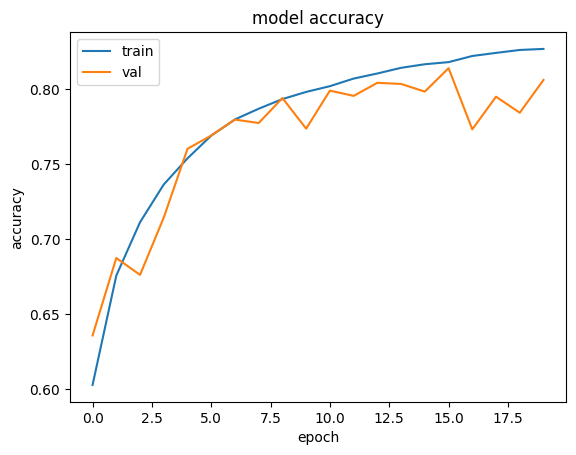

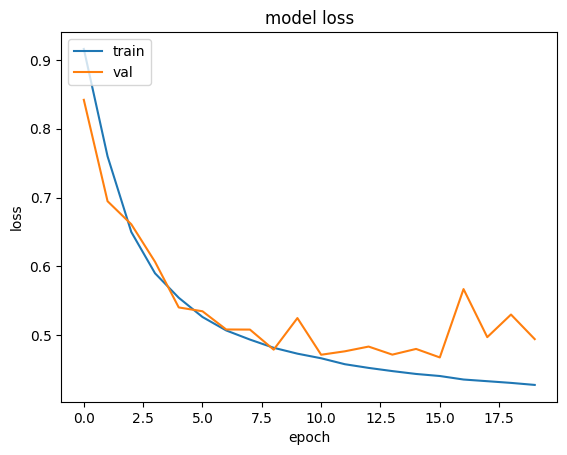

Epoch 1/10
3077/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8366 - loss: 0.4119
Epoch 1: val_loss improved from inf to 0.45756, saving model to /content/drive/MyDrive/training_checkpoints/cp-0001.weights.h5
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.8366 - loss: 0.4118 - val_accuracy: 0.8143 - val_loss: 0.4576
Epoch 2/10
3082/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8458 - loss: 0.3928
Epoch 2: val_loss did not improve from 0.45756
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.8458 - loss: 0.3928 - val_accuracy: 0.8122 - val_loss: 0.4646
Epoch 3/10
3082/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8482 - loss: 0.3895
Epoch 3: val_loss did not improve from 0.45756
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.8482 - loss: 0.3895 - val_accuracy: 0.8147 - val_loss: 0.4760
Epoch 4/10
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8525 - loss: 0.3782
Epoch 4: val_loss did not improve from 0.45756
3083/3083 ━━━━━━━━━

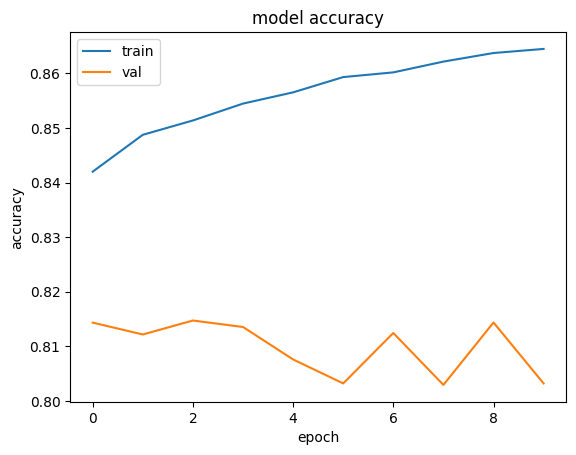

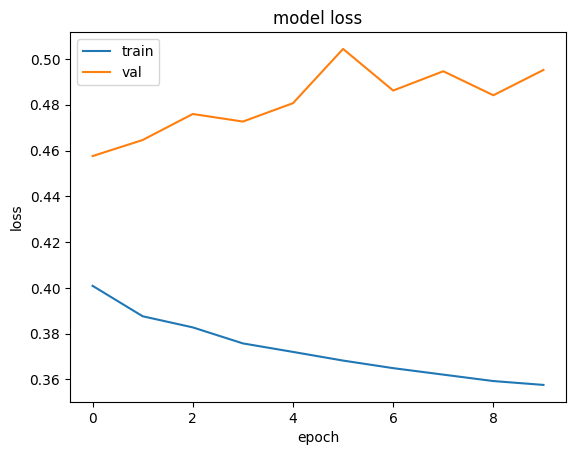

Epoch 1/20
3078/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8736 - loss: 0.3404
Epoch 1: val_loss improved from inf to 0.50433, saving model to /content/drive/MyDrive/training_checkpoints/cp-0001.weights.h5
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - accuracy: 0.8736 - loss: 0.3404 - val_accuracy: 0.8040 - val_loss: 0.5043
Epoch 2/20
3078/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8785 - loss: 0.3289
Epoch 2: val_loss did not improve from 0.50433
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.8785 - loss: 0.3289 - val_accuracy: 0.8070 - val_loss: 0.5128
Epoch 3/20
3078/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8812 - loss: 0.3233
Epoch 3: val_loss did not improve from 0.50433
3083/3083 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.8812 - loss: 0.3233 - val_accuracy: 0.7980 - val_loss: 0.5430
Epoch 4/20
3079/3083 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8839 - loss: 0.3167
Epoch 4: val_loss did not improve from 0.50433
3083/3083 ━━━━━━━

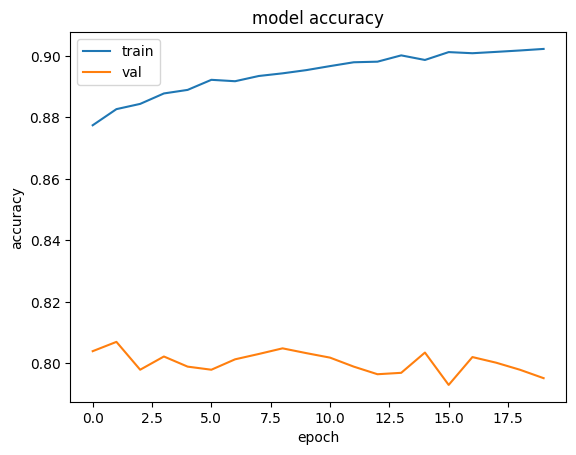

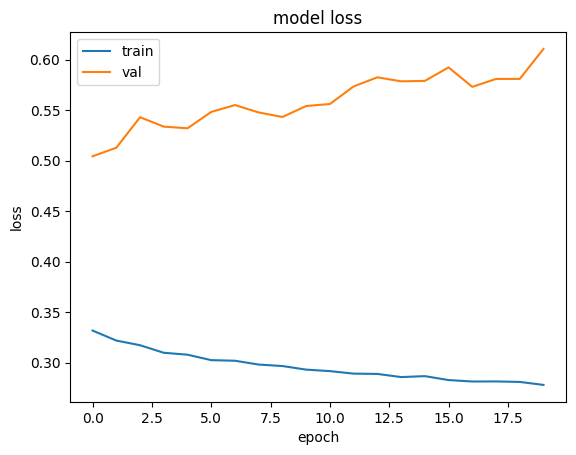

In [ ]:
model = train_epochs(model, train_generator, val_generator, 20, 0.001)
model = train_epochs(model, train_generator, val_generator, 10, 0.0005)
model = train_epochs(model, train_generator, val_generator, 20, 0.00025)

In [ ]:
model.save('/content/drive/MyDrive/trained_models/vww_96.h5')
model.save('/content/drive/MyDrive/trained_models/vww_96.keras')
model.export('/content/drive/MyDrive/trained_models/vww_96')

NameError: name 'model' is not defined